In [1]:
import numpy as np 
import sympy as sym
from filterpy.kalman import KalmanFilter 
import scipy
from scipy.linalg import block_diag
from filterpy.common import Q_discrete_white_noise
from filterpy.common import Saver
import matplotlib.pyplot as plt
from matplotlib import style
import pymap3d as pym
import pandas as pd
from poliastro.bodies import Moon 
from astropy import units as u
from poliastro.twobody.propagation import cowell as cowell
from poliastro.core.perturbations import J3_perturbation, J2_perturbation
from poliastro.core.propagation import func_twobody
import math
from sklearn import linear_model, datasets
import matplotlib.style as style
from numpy.linalg import inv, det
from utility.utils import *
from utility.MieFunzioni import *
from ahrs.filters import AngularRate
from utility.CONFIG import *
from IPython.display import clear_output
from time import sleep
import seaborn as sns
%load_ext autoreload
%autoreload 2

DB = pd.read_csv("orbite/lunar_crater_database_robbins_2018.csv")
df_pos = pd.read_csv('orbite/Position_Fixed.csv')
time = df_pos['Time (UTCG)']
real_X, real_Y, real_Z = df_pos['x (km)'].to_numpy(), df_pos['y (km)'].to_numpy(), df_pos['z (km)'].to_numpy()

#Quaternione e velocita' angolare 
dq = pd.read_csv("orbite/Attitude_Quaternions_Fixed.csv")  
real_teta1, real_teta2, real_teta3 = dq['pitch (deg)'].to_numpy(), dq['yaw (deg)'].to_numpy(), dq['roll (deg)'].to_numpy()
real_om1, real_om2, real_om3 = dq['wx (deg/sec)'].to_numpy(), dq['wy (deg/sec)'].to_numpy(), dq['wz (deg/sec)'].to_numpy()

#Velocita'
dvf = pd.read_csv("orbite/Velocity_Fixed.csv") 
real_Vxs, real_Vys, real_Vzs = dvf['vx (km/sec)'].to_numpy(), dvf['vy (km/sec)'].to_numpy(),dvf['vz (km/sec)'].to_numpy()

# Initial State Vector:
init_x, init_y, init_z = real_X[0], real_Y[0], real_Z[0]
init_vx, init_vy, init_vz = -real_Vxs[0], -real_Vys[0], -real_Vzs[0]
init_teta1, init_teta2, init_teta3 = real_teta1[0], real_teta2[0], real_teta3[0]
init_om1, init_om2, init_om3 = real_om1[0], real_om2[0], real_om3[0]

### Plot Real Positions

<AxesSubplot: >

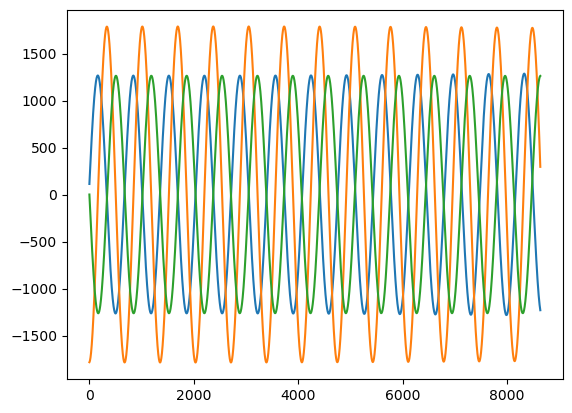

In [6]:
sns.lineplot( x=[x for x in range(len(real_X))], y=real_X)
sns.lineplot( x=[x for x in range(len(real_Y))], y=real_Y)
sns.lineplot( x=[x for x in range(len(real_Z))], y=real_Z)

### Processing

In [2]:
#State transition matrix
dt = 0.1
F=find_F_matrix(real_X[0], real_Y[0], real_Z[0], real_teta1[0], real_teta2[0], real_teta3[0], real_om1[0], real_om2[0], real_om3[0]) 
phii= np.eye(12)+F*dt 

In [ ]:
def randomize(array):
     for idx, item in enumerate(array):
          r = np.random.rand()
          if idx < 2:
               r *=1
          else:
               r /= 10
          item += r
          array[idx] = item

     return array

In [3]:
#Process noise matrix
q = Q_discrete_white_noise(dim=3, dt=dt, var=0.001)
Q = block_diag(q, q, q, q)   
 
X = np.array([[real_X[0], real_Y[0], real_Z[0], real_Vxs[0], real_Vys[0], real_Vzs[0], real_teta1[0], real_teta2[0], real_teta3[0], real_om1[0], real_om2[0], real_om3[0]]]).T
# print('Pre random:', X)
# X = randomize(X)
# print('After random:', X)

P=np.diag([3.65996971, 0.29041806, 682008.0961273, 5.52247218, -18.90088871, 0.23225206, 2.8019472, 2.73023895, 3.0819458, 3.35880549, 1.62408328, 1.5544467])

In [4]:
apriori = {x:[] for x in ['x','y','z','vx','vy','vz']}
epochs = 100
for i in range(int(epochs * 10/dt)):
     (X, P) = kf_predict(X, P, phii, Q) 
     apriori['x'].append(X[0].item())
     apriori['y'].append(X[1].item())
     apriori['z'].append(X[2].item())
     apriori['vx'].append(X[3].item())
     apriori['vy'].append(X[4].item())
     apriori['vz'].append(X[5].item())



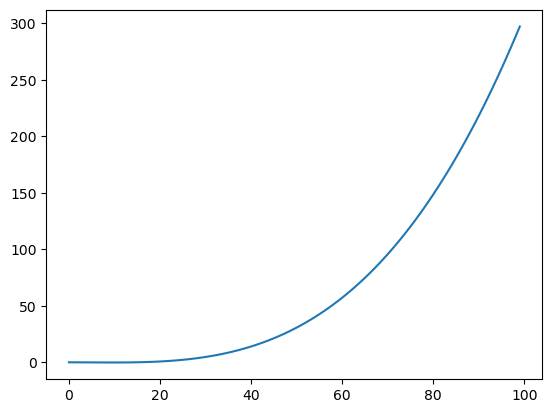

In [5]:
x=apriori['x']
pred=[x[int(10/dt)*i] for i in range(epochs)]
gt=[real_X[i] for i in range(epochs)]
plt.plot([a-b for a,b in zip(pred,gt)])


### Errori sul crs

In [ ]:
x,y,z = real_X[3], real_Y[3], real_Z[3]
h,lat,lon = cartesian2spherical(x, y, z)
print(h, lat, lon)

Controllare il passaggio da coordinate cartesiane a sferiche con quello di STK. Sembra ci sia un problema sui segni.

In [ ]:
lla = pd.read_csv('orbite/LLA.csv')
lla

Esiste un errore dal passaggio di coordinate al più di 150 metri che andrebbe corretto.

In [ ]:
errors = {'x':[],'y':[],'z':[]}
for idx, row in lla.iterrows():
     lat, lon, alt = row['Lat (deg)'], row['Lon (deg)'], row['Alt (km)']
     x,y,z = spherical2cartesian(alt, lat, lon)

     rx, ry, rz = real_X[idx], real_Y[idx], real_Z[idx]
     errors['x'].append(x-rx)
     errors['y'].append(y-ry)
     errors['z'].append(z-rz)

### EKF

In [ ]:
mus = []
N=[]
mus.append(X)
pre=[]
post=[]
pre.append(X)
post.append(X)

K_R = 2000
ULTIMO = 3000
for i in range(ULTIMO):
    # clear_output(wait=True)
    if i==0:
        
        (X, P) = kf_predict(X, P, phii, Q) 
        pre.append(X) #Valore del vettore di stato prima della correzione

        # Filtering DATABASE:
        x,y,z = X[0].item(), X[1].item(), X[2].item()
        h,lat,lon = cartesian2spherical(x, y, z)
        lat_bounds=[lat-SPAN, lat+SPAN]
        lon_bounds=[lon-SPAN,lon+SPAN]
        craters_cat = CatalogSearch(DB, lat_bounds, lon_bounds, CAT_NAME='ROBBINS')

        if craters_cat is None:  
            print ("Non sono stati trovati crateri all'istante ", time[i])
            N.append(0)
        else:
            #Filtro i crateri trovati in base al diametro, vengono scartati tutti quelli con diametro inferiore a 2 metri e 
            #superiore a 25 metri
            indexNames = craters_cat[ (craters_cat['Diam'] <= 2) ].index
            craters_cat.drop(indexNames , inplace=True)
            indexNames = craters_cat[ (craters_cat['Diam'] >= 25) ].index
            craters_cat.drop(indexNames , inplace=True)
            craters_cat = craters_cat.reset_index(drop=True)
            N_crat =len(craters_cat)
            
            if N_crat>5: #se ho più di 5 crateri, ne vengono scelti 5 tra quelli individuati, mentre i restanti vengono scartati
                craters_cat=craters_cat.sample(5)
                craters_cat = craters_cat.reset_index(drop=True)
                N_crat=len(craters_cat)

            else: 
                print(" ") #ho messo un print vuoto perchè continue mi dava problemi  
            
            N.append(N_crat)

            crater_Latitudes, crater_Longitudes = craters_cat['Lat'], craters_cat['Lon']
            print("Sono stati trovati ", N_crat, "crateri all'istante ", time[0])

            x_c, y_c, z_c = [], [], []  #trovo le posizioni dei crateri
            for i_c in range(N_crat):
                altitude = 0
                latitude = crater_Latitudes[i_c]
                longitude = crater_Longitudes[i_c]
                x, y, z = spherical2cartesian(altitude, latitude, longitude)
                x_c.append(x)
                y_c.append(y)
                z_c.append(z)
            x_c, y_c, z_c = np.array(x_c),np.array(y_c),np.array(z_c)
            
            dim_z = 2*N_crat
            
            #Diversi valori per la diagonale della matrice R
            R=np.eye(dim_z)*K_R

            #costruisco la matrice H e le misure
            H_allcraters=np.empty([0,12])
            u_vec_tot=np.empty([0,1])
            for i_crat in range(N_crat): 
                xc_i = x_c[i_crat] 
                yc_i = y_c[i_crat]
                zc_i = z_c[i_crat]
                print(f'Craters coordinates: {xc_i}, {yc_i}, {zc_i}') 
            
                (H_i,u_vec_i)=H_matrix(init_x,init_y, init_z, xc_i,yc_i,zc_i,init_teta1,init_teta2,init_teta3) 

                H_allcraters = np.vstack((H_allcraters, H_i))
                u_vec_tot=np.vstack((u_vec_tot, u_vec_i))
        
            HH = H_allcraters
            mis=u_vec_tot
            HH=HH.astype('float64') #necessario altrimenti alcune componenti della matrice risultavano essere degli oggetti
            mis=mis.astype('float64')
            
            (X, P, K, IM, IS) = kf_update(X, P, mis, HH, R)
            post.append(X) #vettore di stato dopo la correzione
            
    else:     
        ########################################################################
        # PREDICTOR:     
  
        # ics,ips,zet = real_X[i],real_Y[i], real_Z[i]
        # vix,viy,viz = real_Vxs[i],real_Vys[i], real_Vzs[i]
        # qqq1,qqq2,qqq3 = real_q1[i],real_q2[i], real_q3[i]
        # ome1,ome2,ome3=real_om1[i],real_om2[i], real_om3[i]
        # qq4=real_q4[i]

        ics,ips,zet = X[0].item(),X[1].item(), X[2].item()
        vix,viy,viz = X[3].item(),X[4].item(), X[5].item()
        te1,te2,te3 = X[6].item(),X[7].item(), X[8].item()
        ome1,ome2,ome3=X[9].item(),X[10].item(), X[11].item()
        

        F = find_F_matrix(ics,ips,zet,te1,te2,te3,ome1,ome2,ome3)  
        phii = np.eye(12)+F*dt 

        # Predict:
        (X, P) = kf_predict(X, P, phii, Q)
        pre.append(X)

        # Filtering DATABASE:
        x,y,z = X[0].item(), X[1].item(), X[2].item()
        h,lat,lon = cartesian2spherical(x, y, z)
        lat_bounds=[lat-SPAN, lat+SPAN]
        lon_bounds=[lon-SPAN,lon+SPAN]
        craters_cat = CatalogSearch(DB, lat_bounds, lon_bounds, CAT_NAME='ROBBINS')

        if craters_cat is None:  
            print ("Non sono stati trovati crateri all'istante ", time[i])
            N.append(0)

        else: #se vengono visti crateri, le misure sono le linee di vista di tali crateri 

            indexNames = craters_cat[ (craters_cat['Diam'] <= 2) ].index
            craters_cat.drop(indexNames , inplace=True)
            indexNames = craters_cat[ (craters_cat['Diam'] >= 25) ].index
            craters_cat.drop(indexNames , inplace=True)
            craters_cat = craters_cat.reset_index(drop=True)
          
            N_crat =len(craters_cat)

            if N_crat>5:
                craters_cat=craters_cat.sample(5)
                craters_cat = craters_cat.reset_index(drop=True)
                N_crat=len(craters_cat)

            else: 
                print(" ")

            print(" ") #ho separato i due cicli if/else con un print perchè elif mi dava problemi

            if N_crat==0:
                print("Non sono stati trovati crateri all'istante ", time[i])
                N.append(0)
            else:        
                N.append(N_crat)
                crater_Latitudes, crater_Longitudes = craters_cat['Lat'], craters_cat['Lon']
                print("Sono stati trovati ", N_crat, "crateri all'istante ", time[i])

                x_c, y_c, z_c = [], [], []
                for i_c in range(N_crat):
                    altitude = 0
                    latitude = crater_Latitudes[i_c]
                    longitude = crater_Longitudes[i_c]
                    x, y, z = spherical2cartesian(altitude, latitude, longitude)
                    x_c.append(x)
                    y_c.append(y)
                    z_c.append(z)

                x_c, y_c, z_c = np.array(x_c),np.array(y_c),np.array(z_c)
           
                #Matrice di misura
                dim_z = 2*N_crat #z ha dimensione 2*N_crat identificati  

                #Measurement noise matrix
                #R=np.eye(dim_z)*156018.59187512 
                # R=np.eye(dim_z)*1560186.35585705
                R=np.eye(dim_z)*K_R

                H_allcraters=np.empty([0,12])
                u_vec_tot=np.empty([0,1])
                for i_crat in range(N_crat): 
                    xc_i = x_c[i_crat] 
                    yc_i = y_c[i_crat]
                    zc_i = z_c[i_crat] 
                    print(f'Craters coordinates: {xc_i}, {yc_i}, {zc_i}') 
                    
                    (H_i,u_vec_i)=H_matrix(ics,ips, zet, xc_i,yc_i,zc_i,te1,te2,te3) 

                    H_allcraters = np.vstack((H_allcraters, H_i))
                    u_vec_tot=np.vstack((u_vec_tot, u_vec_i))    
        
                HH = H_allcraters
                mis=u_vec_tot
                HH=HH.astype('float64')
                mis=mis.astype('float64')
                (X, P, K, IM, IS) = kf_update(X, P, mis, HH, R)
                post.append(X)


               
    mus.append(X)

    x_pred = [x[0] for x in mus]
    y_pred = [x[1] for x in mus]
    z_pred = [x[2] for x in mus]
    vx_pred = [x[3] for x in mus]
    vy_pred = [x[4] for x in mus]
    vz_pred = [x[5] for x in mus]
    teta1_pred = [x[6] for x in mus]
    teta2_pred = [x[7] for x in mus]
    teta3_pred = [x[8] for x in mus]
    om1_pred = [x[9] for x in mus]
    om2_pred = [x[10] for x in mus]
    om3_pred = [x[11] for x in mus]


    x_true = real_X[:len(x_pred)]
    y_true = real_Y[:len(y_pred)] 
    z_true = real_Z[:len(z_pred)]
    vx_true = real_Vxs[:len(vx_pred)]
    vy_true = real_Vys[:len(vy_pred)]
    vz_true = real_Vzs[:len(vz_pred)]
    teta1_true = real_teta1[:len(teta1_pred)]
    teta2_true = real_teta2[:len(teta2_pred)]
    teta3_true = real_teta3[:len(teta3_pred)]
    om1_true = real_om1[:len(om1_pred)]
    om2_true = real_om2[:len(om2_pred)]
    om3_true = real_om3[:len(om3_pred)]

    def plot_position(K_R,save=False):
        #grafici
        lw=1

        fig=plt.figure(dpi=150, tight_layout=True)
        #plt.figure()
        plt.subplot(3,1,1) 
        plt.plot(x_pred, '-k', linewidth=lw)
        plt.plot(x_true, 'r', linewidth=lw)

        plt.xlabel(f'Step Size: {dt}')
        plt.ylabel('X [Km]')

        plt.subplot(3,1,2) 
        plt.plot(y_pred, '-k', linewidth=lw)
        plt.plot(y_true, 'r', linewidth=lw)
        plt.xlabel(f'Step Size: {dt}')
        plt.ylabel('Y [Km]')

        plt.subplot(3,1,3) 
        plt.plot(z_pred, '-k', linewidth=lw)
        plt.plot(z_true, 'r', linewidth=lw)
        plt.xlabel(f'Step Size: {dt}')
        plt.ylabel('Z [Km]')
        mx, my, mz = np.mean(np.array(x_pred)-np.array(x_true)).item(), np.mean(np.array(y_pred)-np.array(y_true)).item(), np.mean(np.array(z_pred)-np.array(z_true)).item()
        if save:
            plt.savefig(f'imgs/{K_R}_mx_{mx}_my_{my}_mz_{mz}.png')

        plt.show(block=False)




    if i == ULTIMO-1:
        print('Saving:')
        plot_position(K_R, save=True)
    else:
        plot_position(K_R, save=False)

In [ ]:
def plot_velocity():
     lw=1
     plt.figure(dpi=150, tight_layout=True)
     plt.subplot(3,1,1) 
     plt.plot(vx_pred, '-k', linewidth=lw)
     plt.plot(vx_true, 'r', linewidth=lw)
     plt.xlabel(f'Step Size: {dt}')
     plt.ylabel('Vx [km/sec]')

     plt.subplot(3,1,2) 
     plt.plot(vy_pred, '-k', linewidth=lw)
     plt.plot(vy_true, 'r', linewidth=lw)
     plt.xlabel(f'Step Size: {dt}')
     plt.ylabel('Vy [km/sec]')

     plt.subplot(3,1,3) 
     plt.plot(vz_pred, '-k', linewidth=lw)
     plt.plot(vz_true, 'r', linewidth=lw)
     plt.xlabel(f'Step Size: {dt}')
     plt.ylabel('Vz [km/sec]')
     plt.show(block=False)
plot_velocity()

In [ ]:

# plt.figure(dpi=150, tight_layout=True)
# plt.subplot(3,1,1) 
# plt.plot(q1_pred, '-k', linewidth=lw)
# plt.plot(q1_true, 'r', linewidth=lw)
# plt.xlabel(f'Step Size: {dt}')
# plt.ylabel('Q1')

# plt.subplot(3,1,2) 
# plt.plot(q2_pred, '-k', linewidth=lw)
# plt.plot(q2_true, 'r', linewidth=lw)
# plt.xlabel(f'Step Size: {dt}')
# plt.ylabel('Q2')

# plt.subplot(3,1,3) 
# plt.plot(q3_pred, '-k', linewidth=lw)
# plt.plot(q3_true, 'r', linewidth=lw)
# plt.xlabel(f'Step Size: {dt}')
# plt.ylabel('Q3')
# plt.show(block=False)

# plt.figure(dpi=150, tight_layout=True)
# plt.subplot(3,1,1) 
# plt.plot(om1_pred, '-k', linewidth=lw)
# plt.plot(om1_true, 'r', linewidth=lw)
# plt.xlabel(f'Step Size: {dt}')
# plt.ylabel('Omega 1 [°/sec]')

# plt.subplot(3,1,2) 
# plt.plot(om2_pred, '-k', linewidth=lw)
# plt.plot(om2_true, 'r', linewidth=lw)
# plt.xlabel(f'Step Size: {dt}')
# plt.ylabel('Omega 2 [°/sec]')

# plt.subplot(3,1,3) 
# plt.plot(om3_pred, '-k', linewidth=lw)
# plt.plot(om3_true, 'r', linewidth=lw)
# plt.xlabel(f'Step Size: {dt}')
# plt.ylabel('Omega 3 [°/sec]')
# plt.show(block=False)

# plt.figure(dpi=180, tight_layout=True)
# plt.subplot(311)
# x_pred = np.array(x_pred)
# x_true = np.array(x_true)
# diff_x = []
# for x,y in zip(x_pred,x_true):
#     d = (x - y)
#     diff_x.append(d)
# plt.title('Error along X ')
# plt.plot(diff_x, '-k', linewidth=lw)
# plt.ylabel('Km')

# plt.subplot(312)
# y_pred = np.array(y_pred)
# y_true = np.array(y_true)
# diff_y = []
# for x,y in zip(y_pred,y_true):
#     d = (x - y)
#     diff_y.append(d)
# plt.title('Error along Y ')
# plt.plot(diff_y, '-k', linewidth=lw)
# plt.ylabel('Km')

# plt.subplot(313)
# z_pred = np.array(z_pred)
# z_true = np.array(z_true)
# diff_z = []
# for x,y in zip(z_pred,z_true):
#     d = (x - y)
#     diff_z.append(d)
# plt.title('Error along Z ')
# plt.plot(diff_z, '-k', linewidth=lw)
# plt.xlabel(f'Step Size: {dt}')
# plt.ylabel('Km')
# plt.show(block=False)


# plt.figure(dpi=180, tight_layout=True)
# plt.subplot(311)
# vx_pred = np.array(vx_pred)
# vx_true = np.array(vx_true)
# diff_x = []
# for x,y in zip(vx_pred,vx_true):
#     d = (x - y)
#     diff_x.append(d)
# plt.title('Error along Vx')
# plt.plot(diff_x, '-k', linewidth=lw)
# plt.ylabel('Km/sec')

# plt.subplot(312)
# vy_pred = np.array(vy_pred)
# vy_true = np.array(vy_true)
# diff_y = []
# for x,y in zip(vy_pred,vy_true):
#     d = (x - y)
#     diff_y.append(d)
# plt.title('Error along Vy')
# plt.plot(diff_y, '-k', linewidth=lw)
# plt.ylabel('Km/sec')

# plt.subplot(313)
# vz_pred = np.array(vz_pred)
# vz_true = np.array(vz_true)
# diff_z = []
# for x,y in zip(vz_pred,vz_true):
#     d = (x - y)
#     diff_z.append(d)
# plt.title('Error along Vz')
# plt.plot(diff_z, '-k', linewidth=lw)
# plt.xlabel(f'Step Size: {dt}')
# plt.ylabel('Km/sec')
# plt.show(block=False)


# plt.figure(dpi=180, tight_layout=True)
# plt.subplot(311)
# q1_pred = np.array(q1_pred)
# q1_true = np.array(q1_true)
# diff_x = []
# for x,y in zip(q1_pred,q1_true):
#     d = (x - y)
#     diff_x.append(d)
# plt.title('Error in Q1')
# plt.plot(diff_x, '-k', linewidth=lw)

# plt.subplot(312)
# q2_pred = np.array(q2_pred)
# q2_true = np.array(q2_true)
# diff_y = []
# for x,y in zip(q2_pred,q2_true):
#     d = (x - y)
#     diff_y.append(d)
# plt.title('Error in Q2')
# plt.plot(diff_y, '-k', linewidth=lw)

# plt.subplot(313)
# q3_pred = np.array(q3_pred)
# q3_true = np.array(q3_true)
# diff_z = []
# for x,y in zip(q3_pred,q3_true):
#     d = (x - y)
#     diff_z.append(d)
# plt.title('Error in Q3')
# plt.plot(diff_z, '-k', linewidth=lw)
# plt.xlabel(f'Step Size: {dt}')
# plt.show(block=False)

# plt.figure(dpi=180, tight_layout=True)
# plt.subplot(311)
# om1_pred = np.array(om1_pred)
# om1_true = np.array(om1_true)
# diff_x = []
# for x,y in zip(om1_pred,om1_true):
#     d = (x - y)
#     diff_x.append(d)
# plt.title('Error along omega1')
# plt.plot(diff_x, '-k', linewidth=lw)
# plt.ylabel('deg/sec')

# plt.subplot(312)
# om2_pred = np.array(om2_pred)
# om2_true = np.array(om2_true)
# diff_y = []
# for x,y in zip(om2_pred,om2_true):
#     d = (x - y)
#     diff_y.append(d)
# plt.title('Error along omega2')
# plt.plot(diff_y, '-k', linewidth=lw)
# plt.ylabel('deg/sec')

# plt.subplot(313)
# om3_pred = np.array(om3_pred)
# om3_true = np.array(om3_true)
# diff_z = []
# for x,y in zip(om3_pred,om3_true):
#     d = (x - y)
#     diff_z.append(d)
# plt.title('Error along omega3')
# plt.plot(diff_z, '-k', linewidth=lw)
# plt.xlabel(f'Step Size: {dt}')
# plt.ylabel('deg/sec')
# plt.show(block=False)